**IMPORTS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    fbeta_score, roc_auc_score, confusion_matrix
)

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")

**PESO FALSO NEGATIVO**

In [ ]:
# Peso para Fbeta (beta>1 dá mais peso ao recall / falso negativo)
FBETA_BETA = 2


**PADRONIZAR TARGET**

In [2]:
def padronizar_target(df):
    for col in [
        "Class", "class",
        "isFraud", "Fraud", "fraud",
        "FLAG",
        "Label", "label",
        "target", "y",
        "LOAN_DEFAULT",
        "illicit", "Illicit"
    ]:
        if col in df.columns:
            return df.rename(columns={col: "target"})
    raise ValueError("Nenhuma coluna de target conhecida encontrada!")

**CONVERTER COLUNAS NUMERICAS**

In [ ]:
def preprocessar(df):
    # Tratar valores nulos
    df = df.fillna(df.median(numeric_only=True))
    df = df.fillna("missing")

    # Converter colunas categóricas em numéricas
    for col in df.columns:
        if df[col].dtype == "object":
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    return df

**FUNÇÃO PRINCIPAL**

In [ ]:
def rodar_pipeline(dataset_path, dataset_name="Dataset"):
    print("="*60)
    print(f"Rodando pipeline para: {dataset_name}")
    print("="*60)

    # dataset
    df = pd.read_csv(dataset_path)
    df = padronizar_target(df)
    df = preprocessar(df)

    # Filtrar apenas classes 0 e 1
    if set(df["target"].unique()) - {0, 1}:
        df = df[df["target"].isin([0, 1])]

    print("Dimensão:", df.shape)
    print("\nClasses balanceamento:\n", df["target"].value_counts(normalize=True))

    # Gráfico de distribuição
    sns.countplot(x="target", data=df)
    plt.title(f"Distribuição das classes - {dataset_name}")
    plt.show()

    # Divisão treino/teste
    X = df.drop("target", axis=1)
    y = df["target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Balanceamento com SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    print("Antes do SMOTE:", np.bincount(y_train))
    print("Depois do SMOTE:", np.bincount(y_train_res))

    # Normalização
    scaler = StandardScaler()
    X_train_res = scaler.fit_transform(X_train_res)
    X_test = scaler.transform(X_test)

    # Modelos
    modelos = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    }

    resultados = {}

    for nome, modelo in modelos.items():
        modelo.fit(X_train_res, y_train_res)
        y_pred = modelo.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        fBETA = fbeta_score(y_test, y_pred, beta=FBETA_BETA)
        roc = roc_auc_score(y_test, y_pred)

        resultados[nome] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": fBETA,
            "ROC-AUC": roc,
        }

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Matriz de Confusão - {dataset_name} - {nome}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.show()

    # Converter resultados em DataFrame
    df_resultados = pd.DataFrame(resultados).T
    df_resultados["Dataset"] = dataset_name

    # Gráfico de métricas
    df_plot = df_resultados.drop(columns=["Dataset"])
    df_plot.plot(kind="bar", figsize=(10,6))
    plt.title(f"Métricas dos Modelos - {dataset_name}")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(loc="lower right")
    plt.show()

    return df_resultados


**DATASETS**

In [5]:
datasets = {
    "Credit Card": "Dataset/creditcard.csv",
    "Dataset 2": "Dataset/elliptic_txs_classes.csv",
    "Dataset 3": "Dataset/PS_20174392719_1491204439457_log.csv"
}

**FINAL**

Rodando pipeline para: Credit Card
Dimensão: (284807, 31)

Classes balanceamento:
 target
0    0.998273
1    0.001727
Name: proportion, dtype: float64


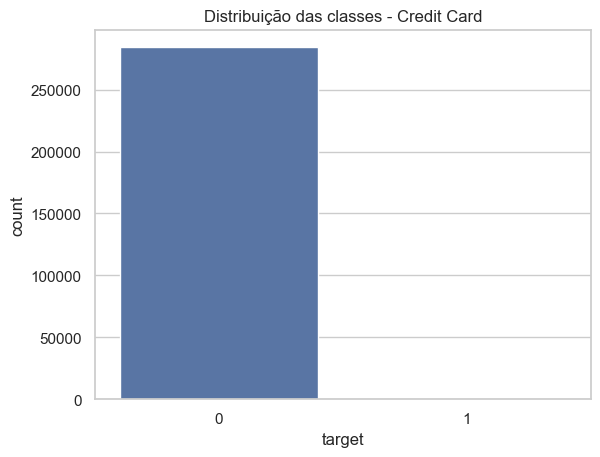

Antes do SMOTE: [199020    344]
Depois do SMOTE: [199020 199020]


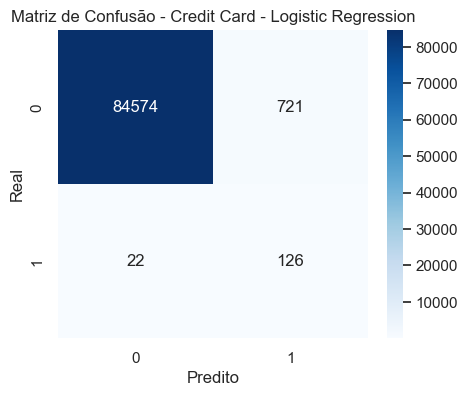

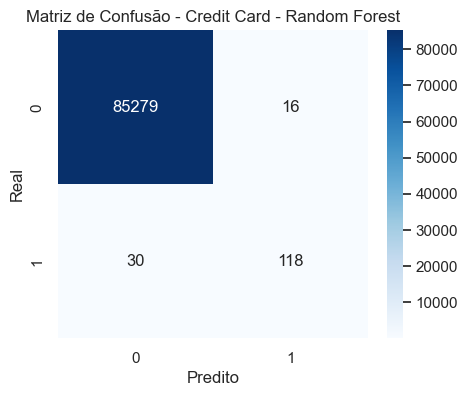

C:\Users\z0051unb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [09:02:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


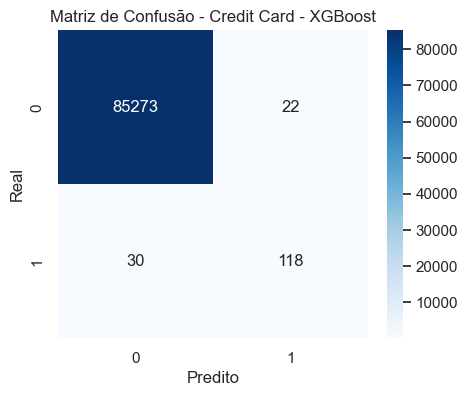

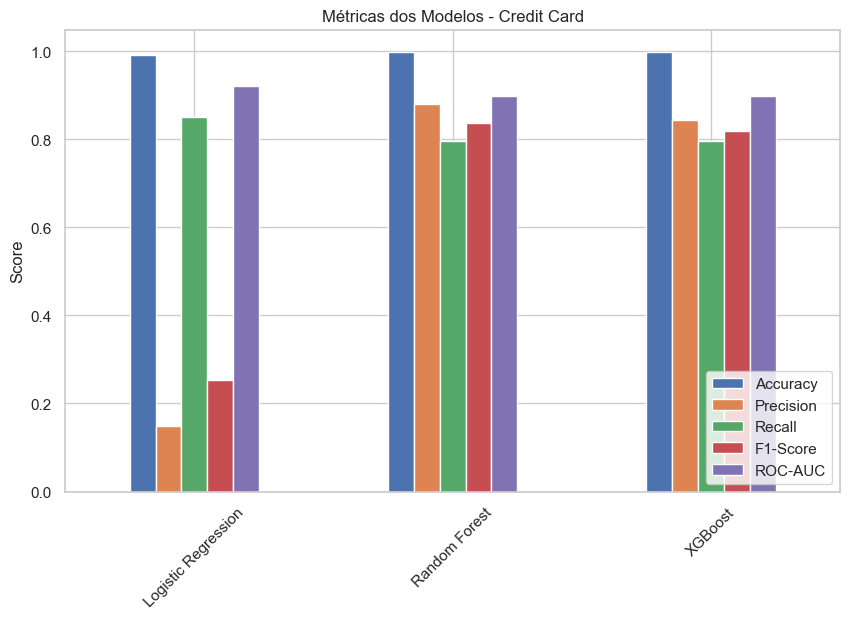

Rodando pipeline para: Dataset 2
Atenção: Dataset 2 possui mais de duas classes. Mantendo apenas 0 e 1.
Dimensão: (46564, 2)

Classes balanceamento:
 target
1    0.902392
0    0.097608
Name: proportion, dtype: float64


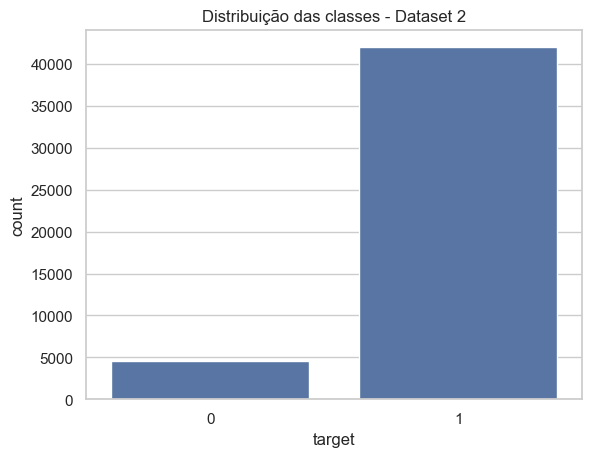

Antes do SMOTE: [ 3181 29413]
Depois do SMOTE: [29413 29413]


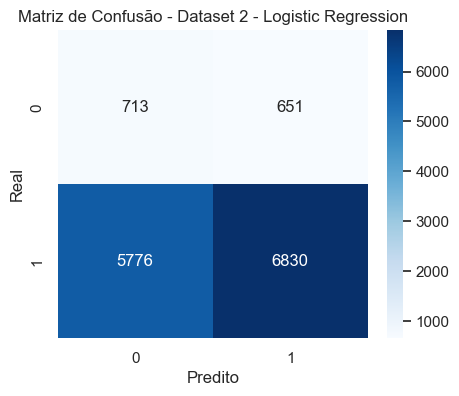

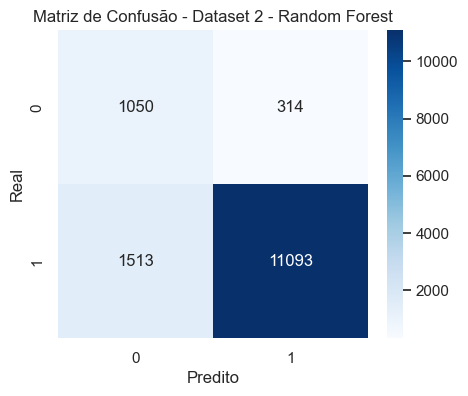

C:\Users\z0051unb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [09:02:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


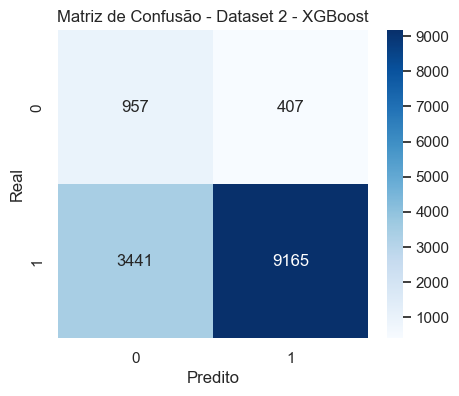

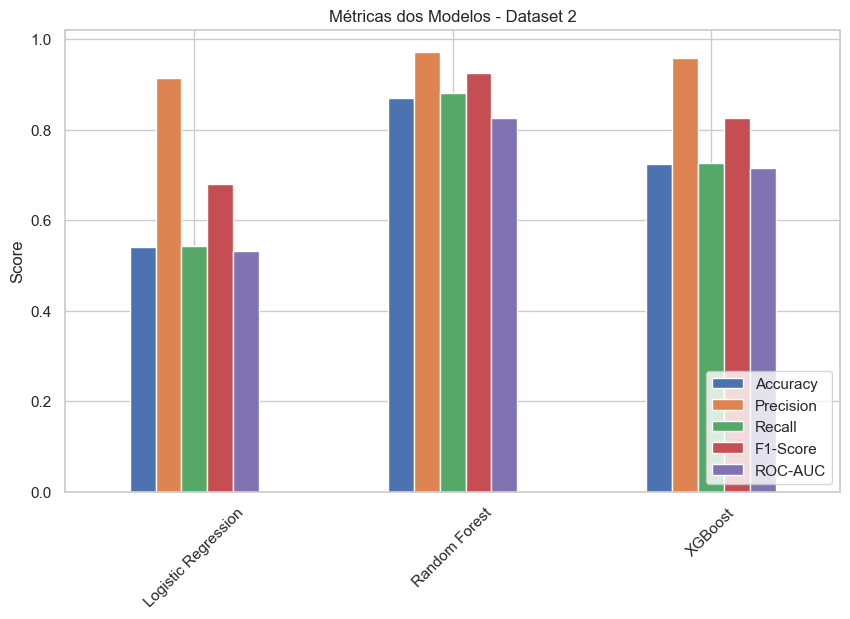

Rodando pipeline para: Dataset 3
Dimensão: (6362620, 11)

Classes balanceamento:
 target
0    0.998709
1    0.001291
Name: proportion, dtype: float64


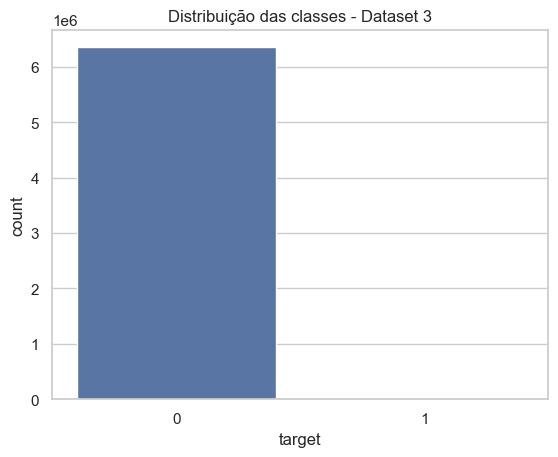

Antes do SMOTE: [4448085    5749]
Depois do SMOTE: [4448085 4448085]


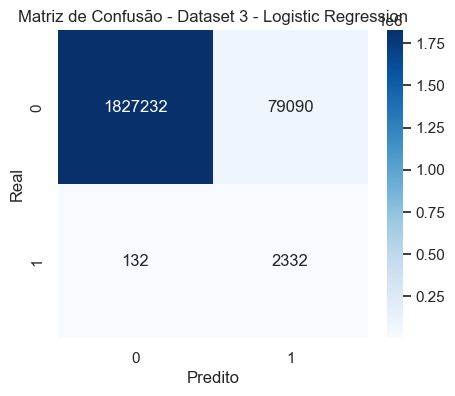

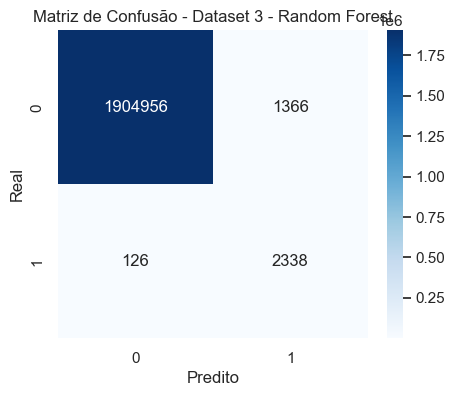

C:\Users\z0051unb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [09:55:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


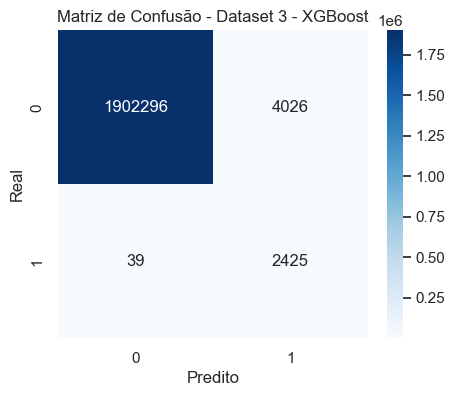

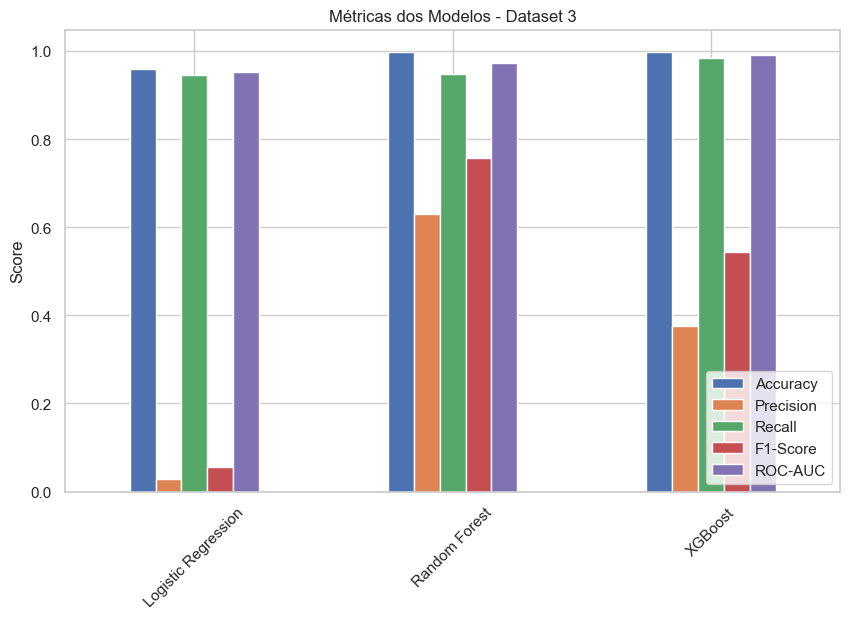

,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Dataset
Logistic Regression,0.991304,0.148760,0.851351,0.253266,0.921449,Credit Card
Random Forest,0.999462,0.880597,0.797297,0.836879,0.898555,Credit Card
XGBoost,0.999391,0.842857,0.797297,0.819444,0.898520,Credit Card
Logistic Regression,0.539943,0.912980,0.541805,0.680042,0.532266,Dataset 2
Random Forest,0.869220,0.972473,0.879978,0.923916,0.824886,Dataset 2
XGBoost,0.724553,0.957480,0.727035,0.826495,0.714324,Dataset 2
Logistic Regression,0.958496,0.028641,0.946429,0.055599,0.952470,Dataset 3
Random Forest,0.999218,0.631210,0.948864,0.758106,0.974074,Dataset 3
XGBoost,0.997870,0.375911,0.984172,0.544027,0.991030,Dataset 3


In [8]:
resultados_gerais = []

for nome, caminho in datasets.items():
    df_res = rodar_pipeline(caminho, dataset_name=nome)
    resultados_gerais.append(df_res)

# Concatenar todos os resultados em um único DataFrame
df_final = pd.concat(resultados_gerais)
df_final